In [1]:
# add path to sispeuede to sys.path in python
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")


path_git = pathlib.Path("/Users/usuario/git")
for subdir in [
    "sisepuede", 
    "sisepuede_data_pipeline",
    # "sisepuede_juypyter"
]:
    path_cur = path_git.joinpath(subdir)
    if str(path_cur) not in sys.path:
        sys.path.append(str(path_cur))

path_pipeline = path_git.joinpath("sisepuede_data_pipeline")


import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import sisepuede.legacy.data_api as api
import sisepuede.manager.sisepuede_examples as sxl
import sisepuede.manager.sisepuede_file_structure as sfs
import sisepuede.manager.sisepuede_models as sm
import sisepuede.visualization.plots as svp
import sisepuede.utilities._plotting as spu
import sisepuede.core.support_classes as sc
import sisepuede.utilities._toolbox as sf
import time

from sisepuede.core.attribute_table import *
from typing import *


import lib.process_utilities as pu
import lib.sisepuede_data_constructs as dc
import lib._util as lutil




In [77]:
### SETUP DIRECTORIES

path_cur = pathlib.Path(os.getcwd())
path_data = path_cur.joinpath("data")
path_transformations = path_cur.joinpath("transformations_libya")
path_attr_tp = path_transformations0.joinpath("attribute_dim_time_period.csv")

##  SETUP FILES




##  SETUP SOME PIPELINE STUFF

# get the time period
attr_time_period = AttributeTable(path_attr_tp, "time_period")
file_struct = sfs.SISEPUEDEFileStructure()

# assign some shortcuts
matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)


##  SOME GLOBALS

_REGION_NAME = "libya"
_REGION_ISO = regions.return_region_or_iso(_REGION_NAME, return_type = "iso", )

path_data_built = pathlib.Path(
    os.path.abspath(f"./input_dat_libya.csv")
    #os.path.abspath(f"../generic_regions/data/output/sisepuede_raw_inputs_latest_{_REGION_ISO}.csv")
)

In [78]:
models = sm.SISEPUEDEModels(
    matt, 
    fp_julia = file_struct.dir_jl,
    fp_nemomod_reference_files = file_struct.dir_ref_nemo,
)

In [79]:
df_libya = pd.read_csv(path_data_built, )
df_libya[regions.key] = _REGION_NAME


In [337]:
import sisepuede.transformers as trf
import sisepuede.transformers.transformations as tmts
importlib.reload(tmts.trs.tbe)
importlib.reload(tmts.trs)

# initialize a transformations set
if not path_transformations.is_dir():
    trf.instantiate_default_strategy_directory(
        transformers,
        path_transformations,
    )




transformations = tmts.Transformations(
    path_transformations,
    #attr_time_period = attr_time_period,
    df_input = df_libya,
)
transformers = transformations.transformers

strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)







In [96]:
strat0 = strategies.get_strategy(0)
df0 = strat0()

df_out = models(
    df0, 
    include_electricity_in_energy = True, 
    time_periods_base = range(11),
    time_periods_run = range(11),
)

2025-03-Nov 20:25:11.993 Opened SQLite database at /Users/usuario/git/sisepuede_region_nbs/morocco/tmp0ndssv7r.sqlite.
2025-03-Nov 20:25:12.002 Added NEMO structure to SQLite database at /Users/usuario/git/sisepuede_region_nbs/morocco/tmp0ndssv7r.sqlite.
2025-03-Nov 20:25:12.792 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-03-Nov 20:25:12.836 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 20:25:22.414 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


In [93]:
um_energy = matt.get_unit("energy")
total_elec = 33746*um_energy.convert("mwh", "pj")*1000
total_elec[]

121.4856

In [112]:
df_out[[x for x in df_out.columns if ("nemomod_entc_annual_production_by_technology" in x)]].iloc[0]

nemomod_entc_annual_production_by_technology_pp_biogas                  0.000000
nemomod_entc_annual_production_by_technology_pp_biomass                 2.085346
nemomod_entc_annual_production_by_technology_pp_coal                    0.000000
nemomod_entc_annual_production_by_technology_pp_coal_ccs                0.000000
nemomod_entc_annual_production_by_technology_pp_gas                     0.000000
nemomod_entc_annual_production_by_technology_pp_gas_ccs                 0.000000
nemomod_entc_annual_production_by_technology_pp_geothermal              0.000000
nemomod_entc_annual_production_by_technology_pp_hydropower              0.000000
nemomod_entc_annual_production_by_technology_pp_nuclear                 0.000000
nemomod_entc_annual_production_by_technology_pp_ocean                   0.000000
nemomod_entc_annual_production_by_technology_pp_oil                   358.476893
nemomod_entc_annual_production_by_technology_pp_solar                  29.886394
nemomod_entc_annual_producti

In [118]:
#df0[[x for x in df0.columns if "" in x]].iloc[0]
df_libya[[x for x in df_libya.columns if "residual_capaci" in x]].iloc[8]
df0[[x for x in df0.columns if "residual" in x]].iloc[0]

# 



(0.06506923890063424, 0.9349307610993657)

In [287]:
_ATTR_LVST = matt.get_attribute_table(matt.subsec_name_lvst, )
_CATS = ["cattle_dairy", "cattle_nondairy", "goats", "sheep"]
_INDS = [_ATTR_LVST.get_key_value_index(x) for x in _ATTR_LVST.key_values if x in _CATS]

# model variables
_MODVAR_LVST_CCS = matt.get_variable("Carrying Capacity Scalar")
_MODVAR_LVST_DMC = matt.get_variable(models.model_afolu.modvar_lvst_dry_matter_consumption)
_MODVAR_LVST_POP_INIT = matt.get_variable("Initial Livestock Head Count")
_MODVAR_LVST_POP = matt.get_variable("Livestock Head Count")

# get arrays--init pop (incl hist)
arr_init = _MODVAR_LVST_POP_INIT.get_from_dataframe(
    df_libya,
    return_type = "array"
)
_MODVAR_LVST_DMC = matt.get_variable(models.model_afolu.modvar_lvst_dry_matter_consumption)

# get projected pop
arr_proj = _MODVAR_LVST_POP.get_from_dataframe(
    df_out,
    return_type = "array",
)

# get est of total consumed dry matter
arr_dmc = _MODVAR_LVST_DMC.get_from_dataframe(
    df_libya,
    return_type = "array",
)
arr_dmc_init = arr_dmc*arr_init
arr_dmc_proj = arr_dmc*arr_proj

vec_scale = np.nan_to_num(
    arr_dmc_init.sum(axis = 1)/arr_dmc_proj.sum(axis = 1),
    nan = 0.0
)


# get inds to use for projecting
vec_pop_total = arr_init.sum(axis = 1, )
for i, val in enumerate(vec_pop_total):
    if i == len(vec_pop_total) - 1: continue

    if vec_pop_total[i + 1] == val: break


vec_scale_red = vec_scale[0:i]
targ_next = sf.project_from_array(
    vec_scale_red[..., None],
    max_deviation_from_mean = 0.5,
)

vec_cc = targ_next*np.ones(df_libya.shape[0])
vec_cc[0:vec_scale_red.shape[0]] = vec_scale_red

# UPDATE
df_libya[_MODVAR_LVST_CCS.fields[0]] = vec_cc

# update here
"""

df_try = models(
    df_libya, 
    include_electricity_in_energy = False, 
    time_periods_base = range(11),
    time_periods_run = range(11),
)


# update fertilizer quickly
# use 20kg/ha, which is a rough approximation from here: https://data.worldbank.org/indicator/AG.CON.FERT.ZS?locations=LY
df_try[[x for x in df_try.columns if "area_lndu" in x and ("conversion" not in x)]]
df_try["area_lndu_croplands"].iloc[0]*20/1000000 # thjis came to 34.173693884797274


"""
df_libya["qtyinit_soil_synthetic_fertilizer_kt"] = 34.174


<function sisepuede.utilities._toolbox.project_from_array(arr_in: numpy.ndarray, max_deviation_from_mean: Optional[float] = 0.2, max_lookback: Optional[int] = None) -> Optional[numpy.ndarray]>

In [362]:
df_libya_ow = df_libya[[
    time_periods.field_time_period,
    "qtyinit_soil_synthetic_fertilizer_kt",
    _MODVAR_LVST_CCS.fields[0]
]]

sf._write_csv(
    df_libya_ow,
    "/Users/usuario/Desktop/libya_var_overwrites.csv",
)

True

In [357]:
df_try = models(
    df_libya, 
    include_electricity_in_energy = False, 
    time_periods_base = range(11),
    time_periods_run = range(11),
)

(<Figure size 1800x1200 with 1 Axes>, <Axes: >)

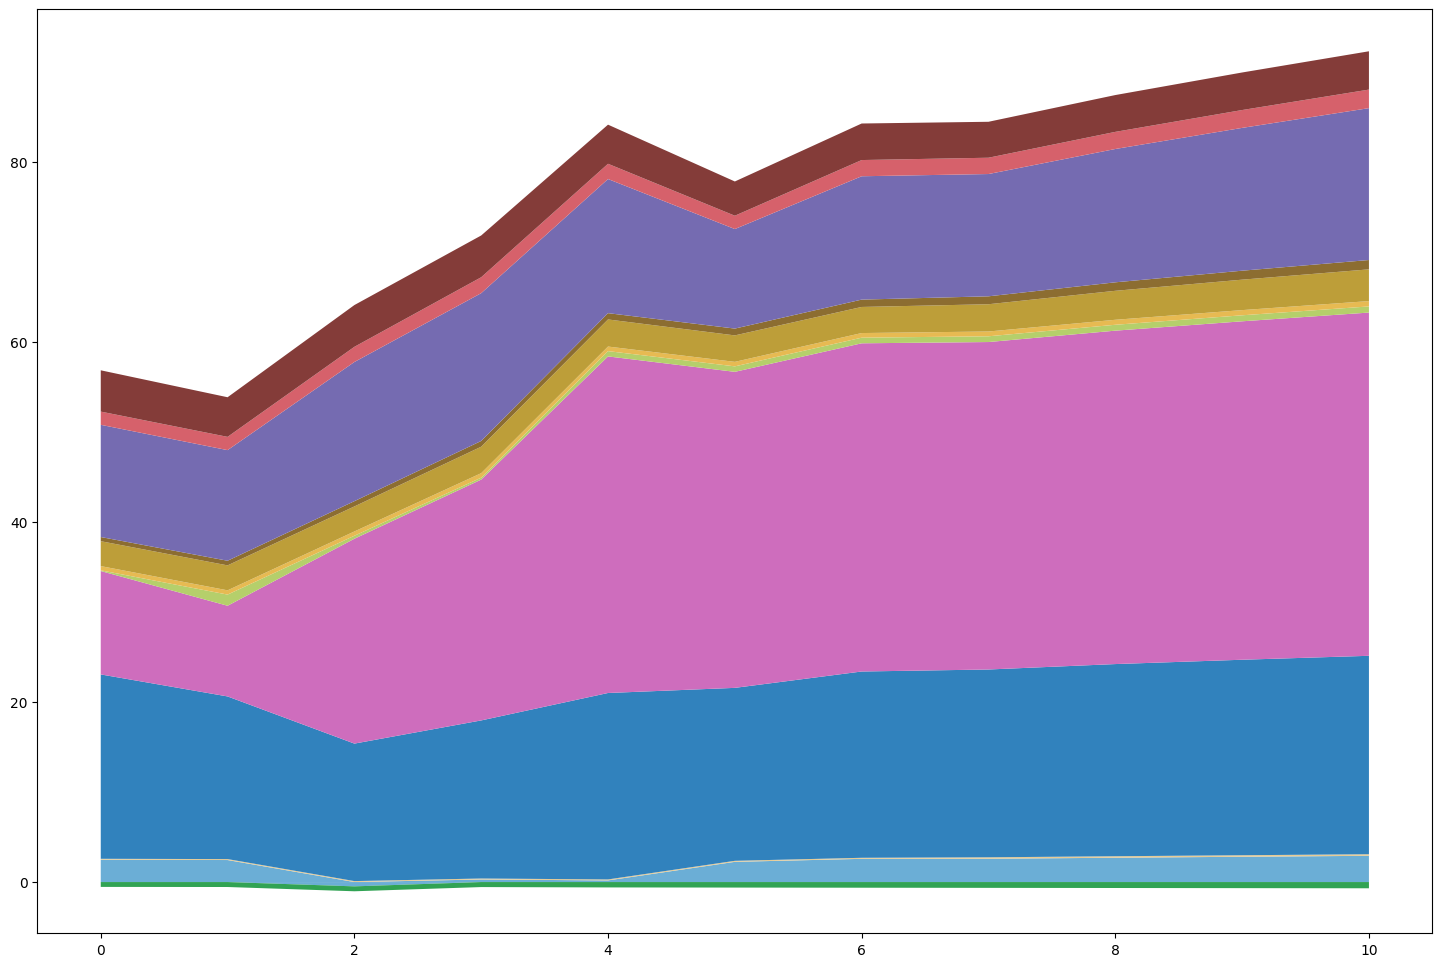

In [358]:
svp.plot_emissions_stack(df_try, matt, )

<Axes: >

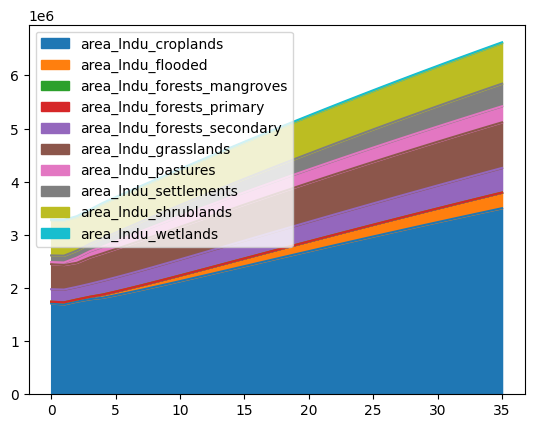

In [242]:
modvar = matt.get_variable("Land Use Area")
flds = [x for x in modvar.fields if "other" not in x]

df_out[flds].plot.area()

In [214]:


##  adjust min share production--we need to get better values for this data
modvar_msp = matt.get_variable(models.model_enerprod.modvar_entc_nemomod_min_share_production)

# shares based from resid cap
share_ng = 8.844445
share_oil = 0.615555
total = share_oil + share_ng

# update fields
field_pp_gas = modvar_msp.build_fields(category_restrictions = "pp_gas", )
field_pp_oil = modvar_msp.build_fields(category_restrictions = "pp_oil", )

dict_new = {
    field_pp_gas: share_ng/total,
    field_pp_oil: share_oil/total, 
}

df_libya[modvar_msp.fields] = 0
for k, v in dict_new.items():
    df_libya[k] = v


# increase gas effic
df_libya["efficfactor_entc_technology_fuel_use_pp_gas"] = 0.55

# adjust exports a bit
# exports from https://www.iea.org/countries/libya/natural-gas
vec_exp = [
    243.162,
    164.159,
    157.319,
    153.899,
    194.940,
    153.899,
    110.466,
    88.919,
    86.184
]
vec_new = np.zeros(df_libya.shape[0], )
vec_new[0:len(vec_exp)] = np.array(np.array(vec_exp))
vec_new[len(vec_exp):] = vec_exp[-1]
df_libya["exports_enfu_pj_fuel_natural_gas"] = vec_new


In [215]:
df_out = models(
    df_libya, 
    time_periods_base = range(11), 
)

2025-03-Nov 22:14:11.751 Started modeling scenario. NEMO version = 2.2.0, solver = HiGHS.
2025-03-Nov 22:14:11.815 Started optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 22:14:23.260 Finished optimizing following years: [1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010].
2025-03-Nov 22:14:23.291 Started optimizing following years: [1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
2025-03-Nov 22:15:30.707 Finished optimizing following years: [1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035].
set ['emission_co2e_co2_entc_bmass_processing_and_refinement_fp_hydrogen_gasification'] = 0 in energy production. FIX WITH NEW fp_hydrogen_gasification_biomass TECH.


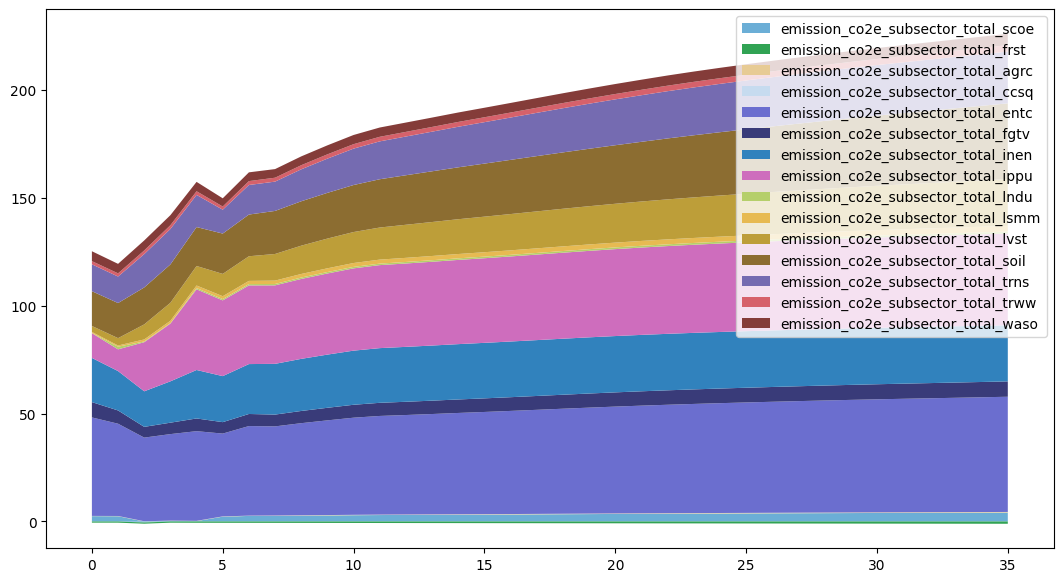

In [224]:
fig, ax = plt.subplots(figsize = (13, 7))
svp.plot_emissions_stack(df_out, matt, figtuple = (fig, ax, ))
ax.legend(loc = "upper right")

In [229]:
df_out[[x for x in df_out.columns if "emission_co2e" in x and "soil" in x]].iloc[0]

emission_co2e_co2_lndu_drained_organic_soils_croplands     0.000000
emission_co2e_co2_lndu_drained_organic_soils_pastures      0.000000
emission_co2e_co2_soil_lime_use                            0.011205
emission_co2e_co2_soil_soc_mineral_soils                   0.013665
emission_co2e_co2_soil_urea_use                            1.392307
emission_co2e_n2o_soil_fertilizer                         14.537475
emission_co2e_n2o_soil_mineral_soils                       0.000160
emission_co2e_n2o_soil_organic_soils                       0.003465
emission_co2e_n2o_soil_paddock_pasture_range               0.170057
emission_co2e_subsector_total_soil                        16.128334
Name: 0, dtype: float64

In [172]:
import sisepuede.utilities._sql as squ
import sqlalchemy


In [175]:
engine = str(path_cur.joinpath("tmp0ndssv7r.sqlite"))
engine = sqlalchemy.create_engine(f"sqlite:///{engine}")

In [190]:
tab = squ.sql_table_to_df(engine, "vusebytechnologyannual")

In [196]:
tab[
    tab["f"].isin(["fuel_natural_gas"])
    & tab["y"].isin(["1000"])
]

,r,t,f,y,val,solvedtm
95,costa_rica,me_coal,fuel_natural_gas,1000,0.249571,2025-11-03 21:47:59.193
237,costa_rica,pp_gas,fuel_natural_gas,1000,1201.636486,2025-11-03 21:47:59.193


In [197]:
tab_prod = squ.sql_table_to_df(engine, "vproductionbytechnologyannual")

In [198]:
tab_prod[
    tab_prod["f"].isin(["fuel_electricity"])
    & tab_prod["y"].isin(["1000"])
]

,r,t,f,y,val,solvedtm
8,costa_rica,pp_solar,fuel_electricity,1000,5.827259e-13,2025-11-03 21:47:59.193
171,costa_rica,pp_gas,fuel_electricity,1000,4.806546e+02,2025-11-03 21:47:59.193
255,costa_rica,pp_oil,fuel_electricity,1000,3.345256e+01,2025-11-03 21:47:59.193


In [199]:

tab_iar = squ.sql_table_to_df(engine, "InputActivityRatio")
tab_iar[
    tab_iar["t"].isin(["pp_gas"])
    & tab_iar["y"].isin(["1000"])
]


,id,r,t,f,m,y,val
972,973,costa_rica,pp_gas,fuel_natural_gas,generate,1000,2.5
